In [21]:
# Imports

import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import os
from PIL import Image


from torchvision import datasets, transforms



In [22]:
# Configuration and hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# VAE hyperparameters
vae_latent_dim = 64
vae_hidden_dim = 400
vae_epochs = 5
vae_batch_size = 128
vae_lr = 1e-3

# Diffusion hyperparameters
diffusion_T = 250         # number of diffusion steps
diffusion_epochs = 10
diffusion_batch_size = 128
diffusion_lr = 2e-4


Using device: cuda


In [23]:
import gdown
import zipfile

os.makedirs("celeba_gan", exist_ok=True)

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
attr_url = "https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with zipfile.ZipFile(output, "r") as zipobj:
        zipobj.extractall("celeba_gan")

gdown.download(attr_url, "list_attr_celeba.txt", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /content/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:01<00:00, 25.6MB/s]


'list_attr_celeba.txt'

In [24]:
def map_celeba_to_label(attr):
    blond     = attr['Blond_Hair'] == 1
    brown     = attr['Brown_Hair'] == 1
    glasses   = attr['Eyeglasses'] == 1
    hat       = attr['Wearing_Hat'] == 1

    # priority order (modify as you want)
    if blond:
        return 0
    if brown:
        return 1
    if glasses:
        return 2
    if hat:
        return 3
    return 4   # none of the above


In [25]:
import pandas as pd

attr_file = "list_attr_celeba.txt"
df = pd.read_csv(attr_file, sep=r"\s+", skiprows=1)
df.index = df.index.astype(str)



In [26]:
class CelebAWithAttrs(Dataset):
    def __init__(self, root, attr_df, transform=None):
        self.root = root
        self.attr_df = attr_df
        self.transform = transform

        self.files = sorted(os.listdir(root))  # all jpg images

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.root, img_name)

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # attributes
        attrs = self.attr_df.loc[img_name]
        attrs = attrs.to_dict()

        cond = map_celeba_to_label(attrs)

        return img, cond


In [27]:
# MNIST dataset


transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # [-1, 1]
])


from torchvision.datasets import ImageFolder

dataset = CelebAWithAttrs(
    root="celeba_gan/img_align_celeba",
    attr_df=df,
    transform=transform
)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader_vae = DataLoader(train_dataset, batch_size=vae_batch_size, shuffle=True)
test_loader_vae  = DataLoader(test_dataset, batch_size=vae_batch_size, shuffle=False)


print("Train size:", len(train_dataset), "Test size:", len(test_dataset))


Train size: 182339 Test size: 20260


## 1. VAE: CELEBA → Latent → CELEBA



In [28]:
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),   # 64x32x32
            nn.ReLU(True),

            nn.Conv2d(64, 128, 4, 2, 1), # 128x16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, 4, 2, 1), # 256x8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.Conv2d(256, 512, 4, 2, 1), # 512x4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),
        )

        # The encoder output is shape: (512, 4, 4) → 512*4*4 = 8192
        self.flat_dim = 512 * 4 * 4

        # Latent parameters
        self.fc_mu = nn.Linear(self.flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, latent_dim)

        self.fc_decode = nn.Linear(latent_dim, self.flat_dim)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # 256x8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 128x16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 64x32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),     # 3x64x64
            nn.Tanh()  # output in [-1,1]
        )

    def encode(self, x):
        h = self.encoder_conv(x)
        h = h.view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(z.size(0), 512, 4, 4)
        x_hat = self.decoder_conv(h)
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


In [29]:
def vae_loss(x, x_hat, mu, logvar):
    # Reconstruction loss (pixel MSE)
    recon_loss = F.mse_loss(x_hat, x, reduction='sum')

    # KL divergence
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    loss = (recon_loss + kl) / x.size(0)
    return loss, recon_loss / x.size(0), kl / x.size(0)


In [30]:
vae = VAE().to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=vae_lr)

print(vae)


VAE(
  (encoder_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
  )
  (fc_mu): Linear(in_features=8192, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=8192, out_features=64, bias=True)
  (fc_decode): Linear(in_features=64, out_features=8192, bias=True)
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_si

In [31]:
# Train VAE

vae.train()
for epoch in range(1, vae_epochs + 1):
    total_loss = 0.0
    total_bce = 0.0
    total_kl = 0.0
    n_samples = 0

    for x, _ in train_loader_vae:
        x = x.to(device)

        vae_optimizer.zero_grad()
        x_hat, mu, logvar = vae(x)
        loss, bce, kl = vae_loss(x, x_hat, mu, logvar)
        loss.backward()
        vae_optimizer.step()

        batch_size = x.size(0)
        total_loss += loss.item()
        total_bce += bce.item()
        total_kl += kl.item()
        n_samples += batch_size

    avg_loss = total_loss / n_samples
    avg_bce = total_bce / n_samples
    avg_kl = total_kl / n_samples

    print(f"[VAE] Epoch {epoch:02d} | Loss: {avg_loss:.4f} (BCE {avg_bce:.4f}, KL {avg_kl:.4f})")


[VAE] Epoch 01 | Loss: 335047.9699 (BCE 7.3421, KL 335040.6292)
[VAE] Epoch 02 | Loss: 6.0899 (BCE 5.1784, KL 0.9115)
[VAE] Epoch 03 | Loss: 5.6955 (BCE 4.7463, KL 0.9493)
[VAE] Epoch 04 | Loss: 5.5671 (BCE 4.5431, KL 1.0241)
[VAE] Epoch 05 | Loss: 5.4986 (BCE 4.3514, KL 1.1472)


## Reconstruction

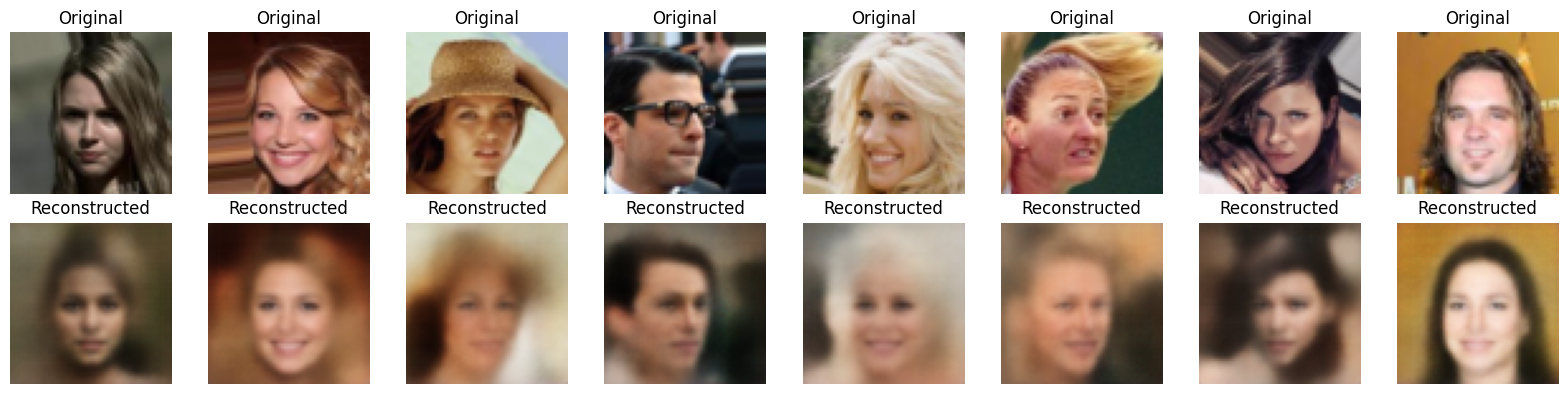

In [32]:
vae.eval()
x_batch, _ = next(iter(test_loader_vae))   # use your CelebA dataloader
x_batch = x_batch.to(device)

with torch.no_grad():
    x_hat, mu, logvar = vae(x_batch)

x_batch = x_batch.cpu()
x_hat = x_hat.cpu()

# Convert from [-1,1] → [0,1] for rendering
x_batch = (x_batch + 1) / 2
x_hat = (x_hat + 1) / 2

# Plot
n = 8
plt.figure(figsize=(2 * n, 4))

for i in range(n):

    plt.subplot(2, n, i + 1)
    plt.imshow(x_batch[i].permute(1, 2, 0))  # (3,64,64) → (64,64,3)
    plt.axis("off")
    plt.title("Original")

    plt.subplot(2, n, n + i + 1)
    plt.imshow(x_hat[i].permute(1, 2, 0))
    plt.axis("off")
    plt.title("Reconstructed")

plt.tight_layout()
plt.show()


## Generation

In [33]:
vae.eval()

@torch.no_grad()
def encode_to_latent(x):
    x = x.to(device)
    mu, logvar = vae.encode(x)
    return mu



In [34]:
# Diffusion utilities

T = diffusion_T

betas = torch.linspace(1e-4, 0.02, T)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

betas = betas.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)

def q_sample(z0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(z0)
    sqrt_alpha_bar = torch.sqrt(alphas_cumprod[t]).view(-1, 1)
    sqrt_one_minus = torch.sqrt(1.0 - alphas_cumprod[t]).view(-1, 1)
    return sqrt_alpha_bar * z0 + sqrt_one_minus * noise

In [35]:
class TimeEmbedding(nn.Module):
    def __init__(self, T, dim):
        super().__init__()
        self.emb = nn.Embedding(T, dim)

    def forward(self, t):
        return self.emb(t)


class ConditionalLatentDenoiser(nn.Module):
    def __init__(self, latent_dim, time_dim=64, cond_dim=64,
                 hidden_dim=512, num_attributes=5, T=250):
        super().__init__()

        # Time embedding: (T → time_dim)
        self.time_emb = nn.Embedding(T, time_dim)

        # Attribute encoder: (5 dim → cond_dim)
        self.attr_encoder = nn.Sequential(
            nn.Linear(num_attributes, cond_dim),
            nn.ReLU(),
            nn.Linear(cond_dim, cond_dim)
        )

        # Total conditioning dimension after concat
        total_cond_dim = time_dim + cond_dim

        # FiLM projection → produce gamma & beta
        self.film = nn.Linear(total_cond_dim, hidden_dim * 2)

        # Main denoiser MLP
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim)

    def forward(self, z_t, t, attr_vec):
        """
        z_t: (B, latent_dim)
        t: (B,) timestep
        attr_vec: (B, 5) binary attributes
        """
        # Time embedding
        t_emb = self.time_emb(t)  # (B, time_dim)

        # Attribute embedding
        a_emb = self.attr_encoder(attr_vec.float())   # (B, cond_dim)

        # Combined conditioning vector
        cond = torch.cat([t_emb, a_emb], dim=1)

        # FiLM conditioning
        gamma, beta = self.film(cond).chunk(2, dim=1)   # (B, hidden_dim)

        # Denoising path
        h = self.fc1(z_t)                 # (B, hidden_dim)
        h = F.relu(h)

        # Apply FiLM: h' = h * (1 + gamma) + beta
        h = h * (1 + gamma) + beta

        h = F.relu(self.fc2(h))
        eps = self.fc3(h)

        return eps


In [36]:
num_attributes = 5   # blond, brown, glasses, hat, none
diffusion_model = ConditionalLatentDenoiser(
    latent_dim=vae_latent_dim,
    time_dim=64,
    cond_dim=64,
    hidden_dim=512,
    num_attributes=num_attributes,
    T=T
).to(device)

diffusion_optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=2e-4)

print(diffusion_model)


ConditionalLatentDenoiser(
  (time_emb): Embedding(250, 64)
  (attr_encoder): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (film): Linear(in_features=128, out_features=1024, bias=True)
  (fc1): Linear(in_features=64, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=64, bias=True)
)


In [37]:
train_loader_diffusion = DataLoader(train_dataset, batch_size=diffusion_batch_size, shuffle=True)


In [38]:
diffusion_model.train()

for epoch in range(1, diffusion_epochs + 1):
    total_loss = 0.0
    n_batches = 0

    for x, attr in train_loader_diffusion:
      x = x.to(device)
      attr = attr.to(device)
      batch_size = x.size(0)

      with torch.no_grad():
          mu, logvar = vae.encode(x)
          z0 = mu

      t = torch.randint(0, T, (batch_size,), device=device, dtype=torch.long)
      noise = torch.randn_like(z0)
      z_t = q_sample(z0, t, noise)

      # Convert integer attributes to one-hot
      attr_onehot = F.one_hot(attr, num_classes=num_attributes).float()

      # Forward pass through conditional denoiser
      eps_pred = diffusion_model(z_t, t, attr_onehot)

      loss = F.mse_loss(eps_pred, noise)

      diffusion_optimizer.zero_grad()
      loss.backward()
      diffusion_optimizer.step()

      total_loss += loss.item()
      n_batches += 1

    avg_loss = total_loss / n_batches
    print(f"[Diffusion] Epoch {epoch:02d} | MSE loss: {avg_loss:.6f}")


[Diffusion] Epoch 01 | MSE loss: 0.683060
[Diffusion] Epoch 02 | MSE loss: 0.592290
[Diffusion] Epoch 03 | MSE loss: 0.576163
[Diffusion] Epoch 04 | MSE loss: 0.566228
[Diffusion] Epoch 05 | MSE loss: 0.561646
[Diffusion] Epoch 06 | MSE loss: 0.554138
[Diffusion] Epoch 07 | MSE loss: 0.551919
[Diffusion] Epoch 08 | MSE loss: 0.548805
[Diffusion] Epoch 09 | MSE loss: 0.545721
[Diffusion] Epoch 10 | MSE loss: 0.541737


In [43]:
# Sampling from diffusion + decode with VAE

def p_sample_step(z_t, t, attr_onehot):
    # Noise prediction
    eps_pred = diffusion_model(z_t, t, attr_onehot)

    # Extract per-sample alpha
    alpha = alphas[t].view(-1, 1)          # (batch, 1)
    alpha_bar = alphas_cumprod[t].view(-1, 1)
    beta = betas[t].view(-1, 1)

    # DDPM sampling
    z0_pred = (z_t - ((1 - alpha).sqrt() * eps_pred)) / alpha.sqrt()

    # Stop at final step
    if (t == 0).all():
        return z0_pred

    noise = torch.randn_like(z_t)
    z_prev = alpha_bar.sqrt() * z0_pred + (1 - alpha_bar).sqrt() * noise
    return z_prev




@torch.no_grad()
def sample_latent_and_decode(n_samples=16, attr_id=0):
    diffusion_model.eval()
    vae.eval()

    # Start from Gaussian noise
    z_t = torch.randn(n_samples, vae_latent_dim, device=device)

    # Attribute tensor (same attr for all samples)
    attr = torch.full((n_samples,), attr_id, device=device, dtype=torch.long)

    # Convert to one-hot
    attr_onehot = F.one_hot(attr, num_classes=num_attributes).float()

    # Reverse diffusion
    for t in reversed(range(T)):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        z_t = p_sample_step(z_t, t_batch, attr_onehot)

    # Decode
    x_hat = vae.decode(z_t)

    # [-1,1] → [0,1]
    x_hat = (x_hat + 1) / 2
    return x_hat.cpu()



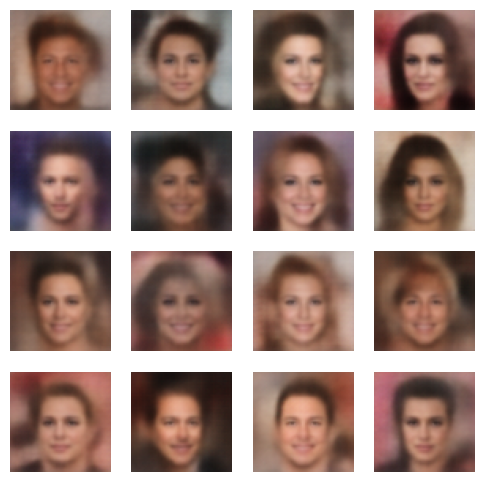

In [50]:
samples = sample_latent_and_decode(16, attr_id=2)
plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(samples[i].permute(1,2,0))
    plt.axis("off")
plt.show()


In [49]:
torch.save({
    "vae_state": vae.state_dict(),
    "diffusion_state": diffusion_model.state_dict(),
    "optimizer_state": diffusion_optimizer.state_dict(),
}, "checkpoint_celeba.pth")
